**Importing dependencies:**

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [10]:
df= pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [11]:
df.shape

(7043, 21)

In [12]:
pd.set_option("display.max_columns", None)

In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
df= df.drop(columns="customerID")

In [15]:
numerical_features= ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in df.columns:
  if col  not in numerical_features:
    print(col, df[col].unique())
    print('-'*50)


gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
--------------------------------------------------
DeviceProtection ['No' 'Yes' 'No internet service']
--------------------------------------------------
TechSupport ['No' 'Yes' 'No internet service']
--------------------------------------------------
StreamingTV ['No' 'Yes' 'No internet 

In [16]:
df['TotalCharges']= df['TotalCharges'].replace(' ', '0.0')

In [17]:
df['TotalCharges']= df['TotalCharges'].astype(float)

In [18]:
type(df['TotalCharges'].iloc[0])

numpy.float64

Dataset is clearly skewed so we need to balance it before training the model

In [20]:
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


**Basic EDA:**

In [19]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [21]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  col_mean= df[column_name].mean()
  col_median= df[column_name].median()

  plt.axvline(col_mean, color='red', linestyle="--", label="Mean")
  plt.axvline(col_median, color='green', linestyle='-', label="Median")

  plt.legend()
  plt.show()

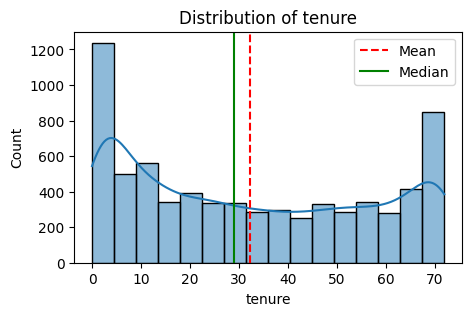

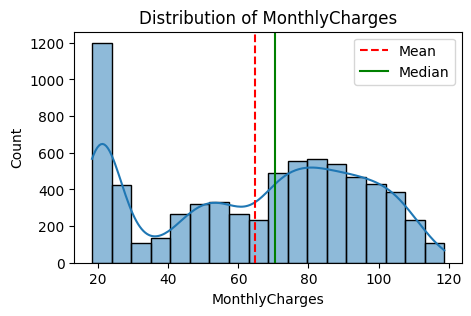

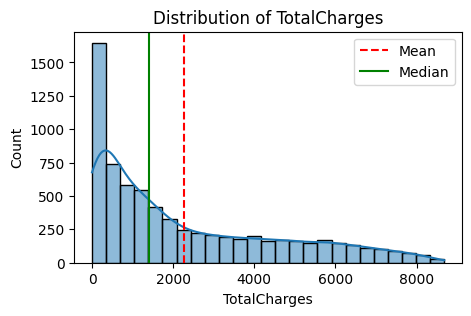

In [22]:
for col in numerical_features:
  plot_histogram(df, col)

In [23]:
def plot_boxplot(df, column_name):
  plt.figure(figsize=(5, 3))
  sns.boxplot(y= df[column_name])
  plt.ylabel(column_name)
  plt.title(f"Distribution of {column_name}")

  plt.show()

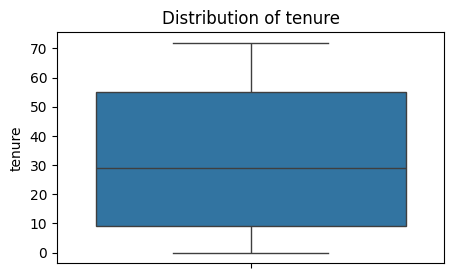

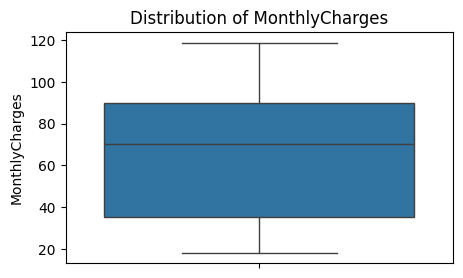

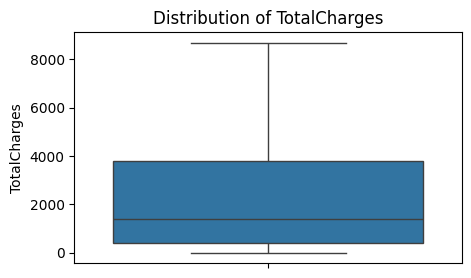

In [24]:
for col in numerical_features:
  plot_boxplot(df, col)

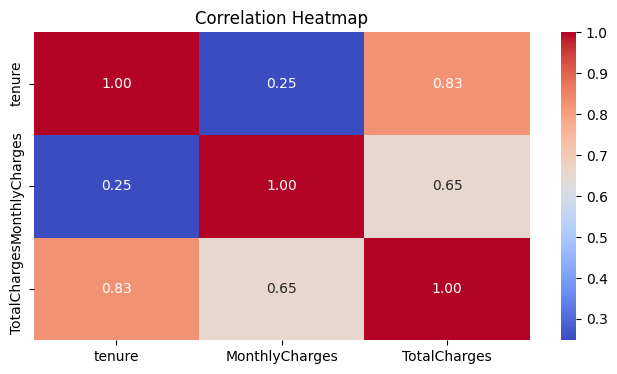

In [25]:
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr(), annot=True, cmap="coolwarm", fmt=".2f" )
plt.title("Correlation Heatmap")

plt.show()

We can see here that tenure and TotalCharges have a high correlation value so we can try dropping oneof the columns in further iterations




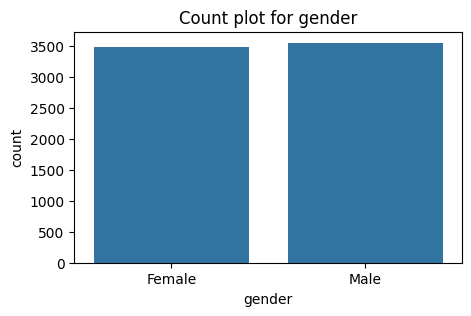

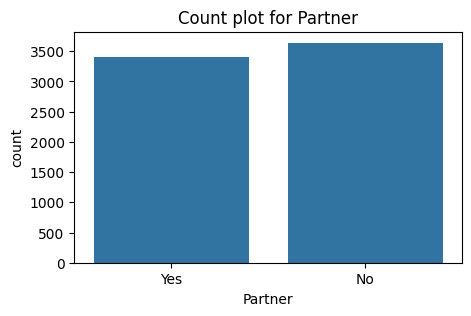

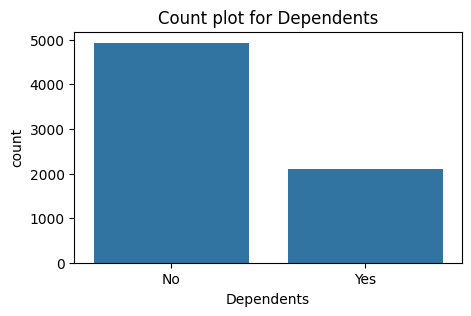

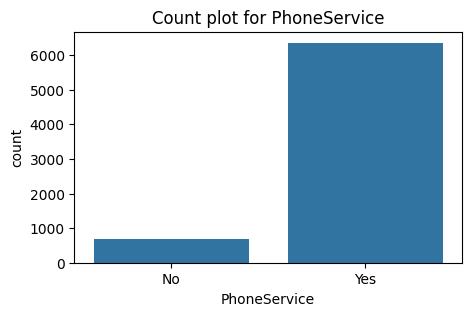

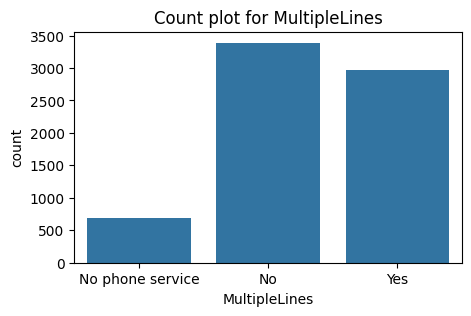

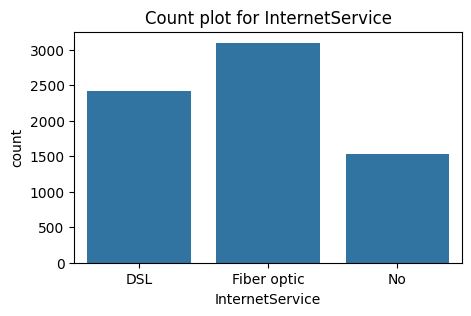

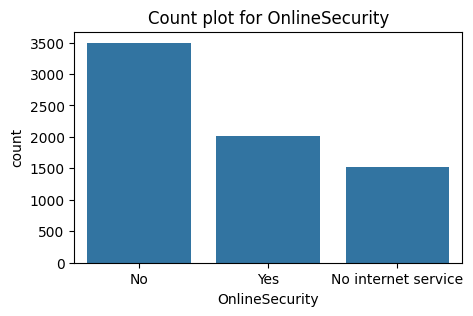

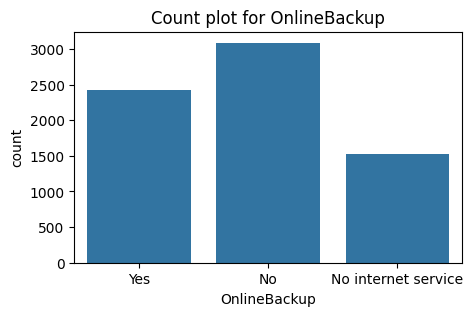

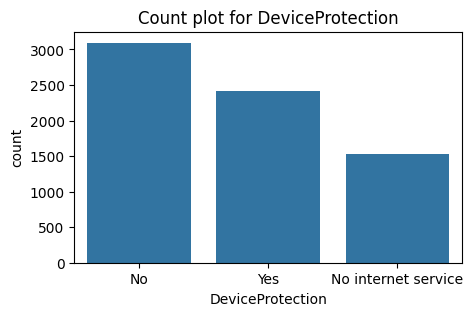

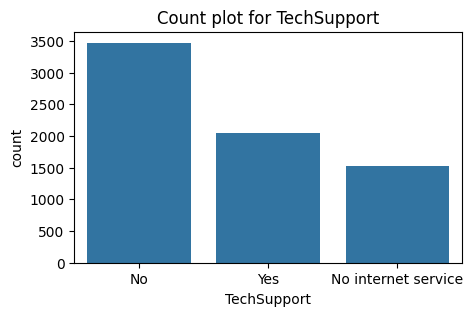

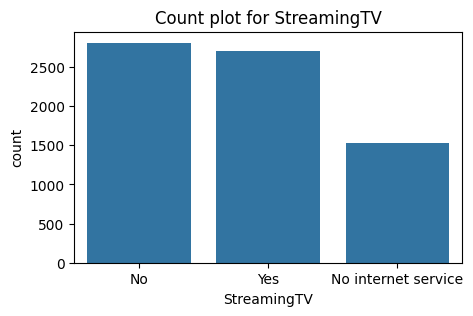

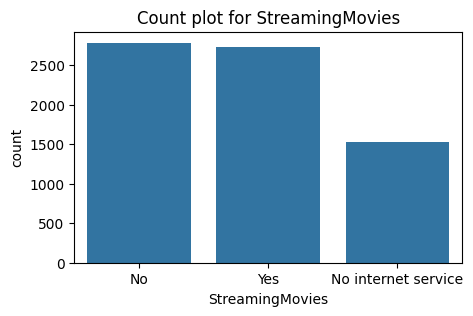

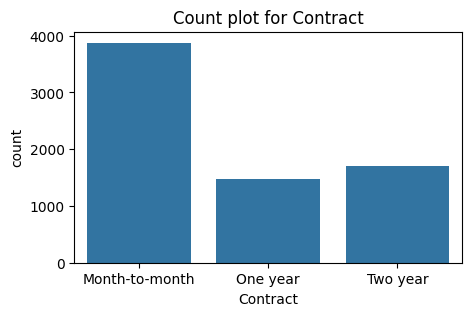

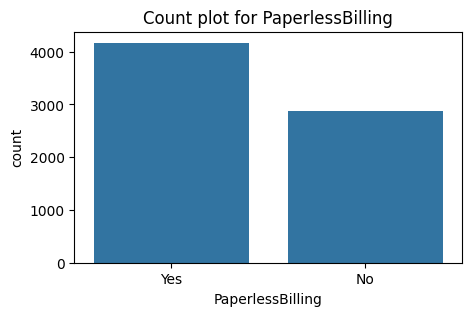

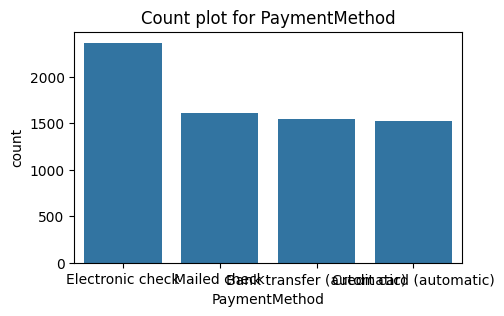

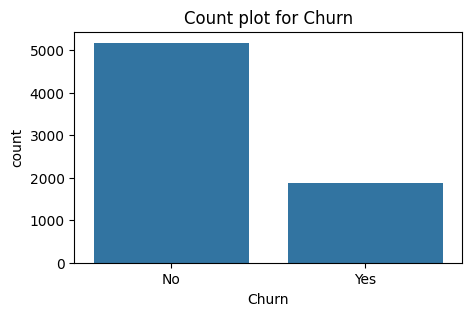

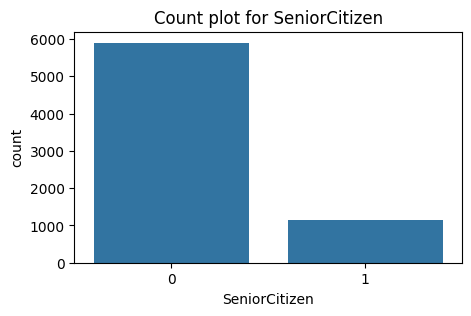

In [26]:
object_cols= df.select_dtypes(include="object").columns.to_list()

object_cols= object_cols+ ["SeniorCitizen"]

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x= df[col])
  plt.title(f"Count plot for {col}")
  plt.show()


In [27]:
df["Churn"]= df["Churn"].replace({"yes": 1, "no": 0})

In [29]:
encoders= {}

for col in object_cols:
  if(col=="Churn"):
    continue
  label_encoder= LabelEncoder()
  df[col]= label_encoder.fit_transform(df[col])
  encoders[col]= label_encoder

  with open("encoders.pkl", "wb") as f:
    pickle.dump(encoders, f)


In [30]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder(),
 'SeniorCitizen': LabelEncoder()}

In [ ]:
X= df.drop(columns= "Churn")
Y= df["Churn"]

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=45, shuffle=True)

In [ ]:
smote= SMOTE(random_state=45)
x_train_smote, y_train_smote= smote.fit_resample(x_train, y_train)

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=45),
    "Random Forest": RandomForestClassifier(random_state=45),
    "CatBoost": CatBoostClassifier(random_state=45, verbose=0) # CatBoost added, verbose=0 to suppress output
}

In [ ]:
param_grid = {
    'Decision Tree': {'max_depth': [None, 5, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10, 20]},
    'CatBoost': {'iterations': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2],
                 'depth': [4, 6, 8]} # CatBoost parameters
}

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=45)

In [ ]:
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name],
                               scoring='accuracy', cv=skf, n_jobs=-1, verbose=2)
    grid_search.fit(x_train_smote, y_train_smote)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best accuracy for {model_name}: {grid_search.best_score_}")

    # Store the best model
    models[model_name] = grid_search.best_estimator_

Tuning Decision Tree...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Best accuracy for Decision Tree: 0.8062143885146693
Tuning Random Forest...
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best accuracy for Random Forest: 0.8495593908150385
Tuning CatBoost...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best parameters for CatBoost: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
Best accuracy for CatBoost: 0.8449477403296017


In [ ]:
rfc= RandomForestClassifier(random_state=45)

In [ ]:
rfc.fit(x_train_smote, y_train_smote)

RandomForestClassifier(random_state=45)

**Model Evaluation:**

In [ ]:
y_test_pred= rfc.predict(x_test)

print("Accuracy Score:/n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:/n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:/n", classification_report(y_test, y_test_pred))

Accuracy Score:/n 0.7906316536550745
Confusion Matrix:/n [[894 162]
 [133 220]]
Classification Report:/n               precision    recall  f1-score   support

           0       0.87      0.85      0.86      1056
           1       0.58      0.62      0.60       353

    accuracy                           0.79      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.80      0.79      0.79      1409



In [ ]:
model_data= {
    "model": rfc,
    "feature_names": X.columns.to_list()
}
with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

In [ ]:
print(X)

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          0              0        1           0       1             0   
1          1              0        0           0      34             1   
2          1              0        0           0       2             1   
3          1              0        0           0      45             0   
4          0              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
7038       1              0        1           1      24             1   
7039       0              0        1           1      72             1   
7040       0              0        1           1      11             0   
7041       1              1        1           0       4             1   
7042       1              0        0           0      66             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 1                0     

In [ ]:
print(encoders)

{'gender': LabelEncoder(), 'Partner': LabelEncoder(), 'Dependents': LabelEncoder(), 'PhoneService': LabelEncoder(), 'MultipleLines': LabelEncoder(), 'InternetService': LabelEncoder(), 'OnlineSecurity': LabelEncoder(), 'OnlineBackup': LabelEncoder(), 'DeviceProtection': LabelEncoder(), 'TechSupport': LabelEncoder(), 'StreamingTV': LabelEncoder(), 'StreamingMovies': LabelEncoder(), 'Contract': LabelEncoder(), 'PaperlessBilling': LabelEncoder(), 'PaymentMethod': LabelEncoder(), 'Churn': LabelEncoder(), 'SeniorCitizen': LabelEncoder()}
